In [1]:
%reset
import numpy as np
import sys,os
import readgadget
import MAS_library as MASL
import pickle as pk
import readfof
import matplotlib
import h5py as h5
import matplotlib.pyplot as pl
pl.rc('text', usetex=False)
# Palatino
pl.rc('font', family='DejaVu Sans')
%matplotlib inline


%load_ext Cython

# # This routine computes the density field and save results to file
# def compute_df(snapshot, ptypes, grid, fout):
#     # if not(os.path.exists(snapshot+'.0')) and not(os.path.exists(snapshot+'.0.hdf5')):
#         # return 0
#     print(snapshot)
#     df = MASL.density_field_gadget(snapshot, pt'ypes, grid, MAS='CIC',
#                                    do_RSD=False, axis=0, verbose=True)
#     df = df/np.mean(df, dtype=np.float64)-1.0
#     np.save(fout, df)
    

    
    


In [2]:
%%cython

cimport numpy as np
cpdef void NGP_mass(np.float32_t[:,:] pos, np.float32_t[:] logM, np.float32_t[:,:,:,:] gridM, float BoxSize):

    cdef int axis,dims,coord,nMmax,jM
    cdef long i,particles
    cdef float inv_cell_size
    cdef int index[3]

    # find number of particles, the inverse of the cell size and dims
    particles = pos.shape[0];  coord = pos.shape[1];  dims = gridM.shape[0]; nMmax = gridM.shape[3]
    inv_cell_size = dims/BoxSize

    # when computing things in 2D, use the index[2]=0 plane
    for i in range(3):  index[i] = 0

    # do a loop over all particles
    for i in range(particles):
        for axis in range(coord):
            index[axis] = <int>(pos[i,axis]*inv_cell_size + 0.5)
            index[axis] = (index[axis]+dims)%dims
        for jM in range(nMmax):
            if gridM[index[0],index[1],index[2], jM] == 0:
                gridM[index[0],index[1],index[2], jM] = logM[i]
                break
            else:
                pass
        
        
        

In file included from /mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /dev/shm/.cache-spandey/ipython/cython/_cython_magic_8000a7727c451ae88844bdd9f9cbdcc9.c:775:
/mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


In [4]:
# import jax.numpy as jnp
# def get_index(i, j, k, Ngrid):
#     """ Generate 1D index. """

#     return (i % Ngrid) + ((j % Ngrid) * Ngrid) + ((k % Ngrid) * Ngrid * Ngrid)

# def cic(coords, boxsize, Ngrid, ndim):
#     # Create a new grid which will contain the densities
#     grid = jnp.zeros(Ngrid ** ndim, dtype=jnp.float32)

#     # Bin coords into their cells and find distance to cell centre.
#     x_c = jnp.floor(coords[:, 0] * Ngrid / boxsize).astype(int)
#     y_c = jnp.floor(coords[:, 1] * Ngrid / boxsize).astype(int)
#     z_c = jnp.floor(coords[:, 2] * Ngrid / boxsize).astype(int)

#     # Distance to center of cell
#     d_x = coords[:, 0] * Ngrid / boxsize - (x_c + 0.5)
#     d_y = coords[:, 1] * Ngrid / boxsize - (y_c + 0.5)
#     d_z = coords[:, 2] * Ngrid / boxsize - (z_c + 0.5)

#     # Which side of the center is this particle on
#     inc_x = jnp.where(d_x < 0, -1, 1)
#     inc_y = jnp.where(d_y < 0, -1, 1)
#     inc_z = jnp.where(d_z < 0, -1, 1)

#     # Work with absolute values.
#     d_x = jnp.abs(d_x).astype(jnp.float64)
#     d_y = jnp.abs(d_y).astype(jnp.float64)
#     d_z = jnp.abs(d_z).astype(jnp.float64)

#     t_x = 1. - d_x
#     t_y = 1. - d_y
#     t_z = 1. - d_z

#     # Add contributions to 8 cells
#     idx = get_index(x_c, y_c, z_c, Ngrid)
#     grid += jnp.bincount(idx, minlength=Ngrid ** ndim, weights=t_x * t_y * t_z)

#     idx = get_index(x_c + inc_x, y_c, z_c, Ngrid)
#     grid += jnp.bincount(idx, minlength=Ngrid ** ndim, weights=d_x * t_y * t_z)

#     idx = get_index(x_c, y_c + inc_y, z_c, Ngrid)
#     grid += jnp.bincount(idx, minlength=Ngrid ** ndim, weights=t_x * d_y * t_z)

#     idx = get_index(x_c, y_c, z_c + inc_z, Ngrid)
#     grid += jnp.bincount(idx, minlength=Ngrid ** ndim, weights=t_x * t_y * d_z)

#     idx = get_index(x_c + inc_x, y_c + inc_y, z_c, Ngrid)
#     grid += jnp.bincount(idx, minlength=Ngrid ** ndim, weights=d_x * d_y * t_z)

#     idx = get_index(x_c, y_c + inc_y, z_c + inc_z, Ngrid)
#     grid += jnp.bincount(idx, minlength=Ngrid ** ndim, weights=t_x * d_y * d_z)

#     idx = get_index(x_c + inc_x, y_c, z_c + inc_z, Ngrid)
#     grid += jnp.bincount(idx, minlength=Ngrid ** ndim, weights=d_x * t_y * d_z)

#     idx = get_index(x_c + inc_x, y_c + inc_y, z_c + inc_z, Ngrid)
#     grid += jnp.bincount(idx, minlength=Ngrid ** ndim, weights=d_x * d_y * d_z)

#     # TODO: Return overdensity instead of only the count
#     return grid.reshape(Ngrid, Ngrid, Ngrid, order='F')



In [1]:
ji = 1
root = '/mnt/home/spandey/ceph/fastpm/fiducial_HR/hdf5_files/'
z = 0
df = h5.File(root + str(ji) + '/SNAPSHOT_fastpm_B3_z' + str(z) + '.hdf5', 'r')            
pos = df['Position'][:]
# grid = 256
grid = 128
df_cic = np.zeros((grid,grid,grid), dtype=np.float32)
BoxSize = 1000.0
MASL.MA(np.float32(pos), df_cic, BoxSize, 'CIC', verbose=True)
df_pylians_cic = df_cic/np.mean(df_cic, dtype=np.float64)-1.0


NameError: name 'h5' is not defined

In [7]:
ji = 0
root = '/mnt/home/spandey/ceph/fastpm/fiducial/hdf5_files/'
z = 0
df = h5.File(root + str(ji) + '/SNAPSHOT_fastpm_B3_z' + str(z) + '.hdf5', 'r')            
pos = df['Position'][:]
# grid = 256
grid = 128
df_cic = np.zeros((grid,grid,grid), dtype=np.float32)
BoxSize = 1000.0
MASL.MA(np.float32(pos), df_cic, BoxSize, 'CIC', verbose=True)
df_pylians_cic_lres = df_cic/np.mean(df_cic, dtype=np.float64)-1.0



Using CIC mass assignment scheme
Time taken = 0.284 seconds



In [8]:
# df_quijote = '/mnt/home/spandey/ceph/Quijote/fiducial_HR_new/Snapshots/0/snapdir_004'
root = '/mnt/home/fvillaescusa/ceph/Quijote/Snapshots/fiducial_HR'
snapnum = 4
ptypes       = [1]
# grid         = 256
snapshot = '%s/%d/snapdir_%03d/snap_%03d'%(root,ji,snapnum,snapnum)
df_quijote = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='CIC',
                                do_RSD=False, axis=0, verbose=True)
df_quijote = df_quijote/np.mean(df_quijote, dtype=np.float64)-1.0



# df_Uniform_cic_jax = cic(jnp.array(pos), BoxSize, grid, 3)
# df_Uniform_cic_jax = np.array(df_Uniform_cic_jax/np.mean(df_Uniform_cic_jax)-1.0)




Computing density field of particles [1]


1.07374176e+09 should be equal to
1.07374182e+09
Time taken = 39.73 seconds


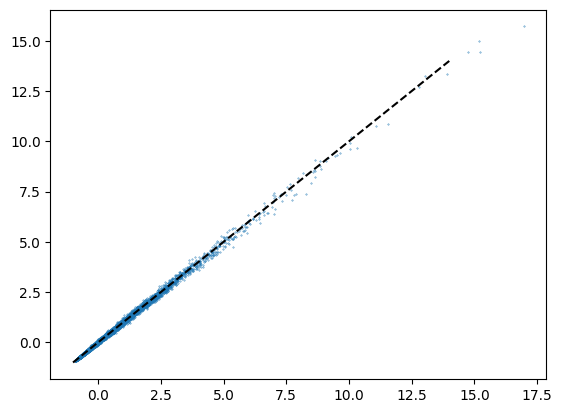

In [9]:
# # df_Uniform_cic_jax
pl.figure()
pl.scatter(df_quijote.flatten()[::100], df_pylians_cic.flatten()[::100], s=0.1)
pl.plot([-1, 14], [-1, 14], 'k--')



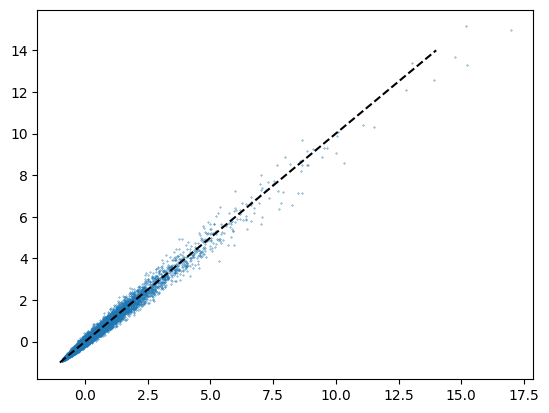

In [10]:
# # df_Uniform_cic_jax
pl.figure()
pl.scatter(df_quijote.flatten()[::100], df_pylians_cic_lres.flatten()[::100], s=0.1)
pl.plot([-1, 14], [-1, 14], 'k--')



In [13]:
arcmin_to_rad = np.pi/180/60
sigma_e = np.array([0.243, 0.262, 0.259, 0.301])
# n_gal = np.array([1.797, 1.552, 1.5967, 1.0979])/arcmin_to_rad**2
n_gal = np.array([1.476, 1.479, 1.484, 1.461])/arcmin_to_rad**2
shape_noise = sigma_e**2/n_gal
print(shape_noise)



[3.38515395e-09 3.92723277e-09 3.82488042e-09 5.24728931e-09]


Text(0.5, 1.0, 'Quijote np=1024^3')

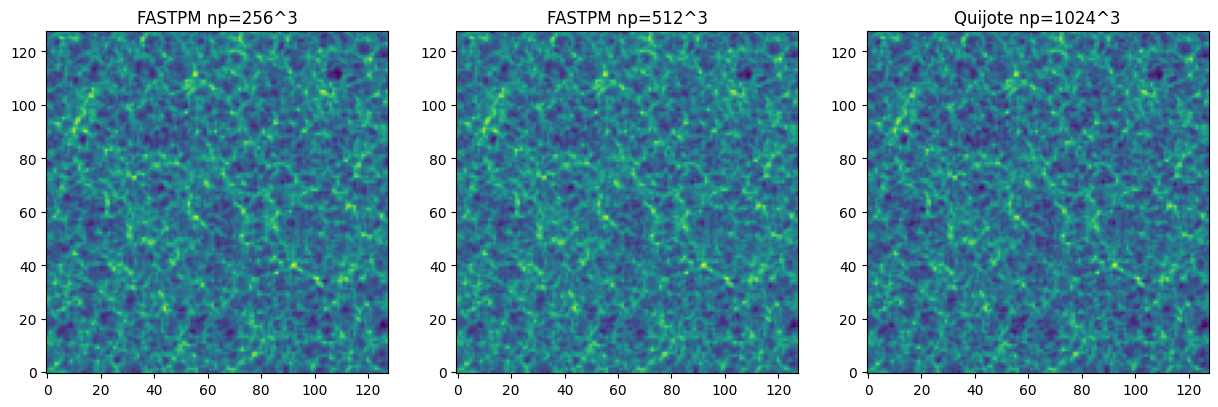

In [25]:
pl.figure(figsize=(15,5))
pl.subplot(131)
pl.imshow(np.log(1+df_pylians_cic_lres[:,:,0]), origin='lower')
pl.title('FASTPM np=256^3')
pl.subplot(132)
pl.imshow(np.log(1+df_pylians_cic[:,:,0]), origin='lower')
pl.title('FASTPM np=512^3')
pl.subplot(133)
pl.imshow(np.log(1+df_quijote[:,:,0]), origin='lower')
pl.title('Quijote np=1024^3')

# pl.colorbar()


In [3]:
import matplolib.pyplot as pl


ModuleNotFoundError: No module named 'matplolib'

In [3]:
# %pip install Pylians
from tqdm import tqdm
# root         = '/mnt/home/spandey/ceph/fastpm'
root = '/mnt/home/spandey/ceph/fastpm/fiducial_HR/hdf5_files/'
root_out     = '/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm'
ptypes       = [1]
# snapnum      = 0
# grids         = [64, 128, 256, 512]
# grids         = [64, 128, 256]
# grids         = [128]
# grids         = [256]
grids         = [128]
BoxSize = 1000.0 #Mpc/h ; size of box
n_batch = 8
n_filter = 3
# n_cnn_all = [0,5,7]
# n_cnn_all = [3]
# n_cnn_all = [0,2,4,8]
# n_cnn_all = [0,4,8,12]
n_cnn_all = [0,4,8]
# n_cnn_all = [0]
# n_sim_tot = 2
# n_sim_array = np.arange(0,10)
# n_sim_array = np.arange(0,2)
# n_sim_array = np.arange(0,6)
# n_sim_array = np.arange(6,13)
# n_sim_array = np.arange(13,21)
n_sim_array = np.arange(0,2)
# snap_num_array = [-1,0,1,2,3,4]
# snap_num_array = [-1,0]
snap_num_array = [1]
# snap_num_array = [-1]
# i = 0
# print(i)
for ji in tqdm(n_sim_array):
    # print('doing sim: ' + str(ji))
    for grid in grids:
        # print('doing res: ' + str(grid))
        for snapnum in snap_num_array:
            z = {0:0, -1: 99, 1:0.5}[snapnum]

            # create output folder if it does not exists
            folder_out = '%s/%d'%(root_out,ji)
            if not(os.path.exists(folder_out)):
                os.system('mkdir %s'%folder_out)

            
            savefname_halos_subvol = '%s/halos_subvol_res_%d_z=%s.pk'%(folder_out,grid,z)
            savefname_halos_full = '%s/halos_full_res_%d_z=%s.pk'%(folder_out,grid,z)            
            
            
            # savefname = folder_out  + '/halo_density_data_dict_' + str(grid) + '.pk'
            # if os.path.exists(fout):  continue

            # compute the density field and save it to file
            # if snapnum > 0:
            #     snapshot = '%s/%d/snapdir_%03d/snap_%03d'%(root,ji,snapnum,snapnum)
            # else:
            #     snapshot = '%s/%d/ICs/ics' % (root, ji)
            # df_cic = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='CIC',
                                        #    do_RSD=False, axis=0, verbose=True)
            # df = h5.File(root + '/SNAPSHOT_fastpm_simfid_' + str(ji) + '_B3_z' + str(z) + '.hdf5', 'r')
            df = h5.File(root + str(ji) + '/SNAPSHOT_fastpm_B3_z' + str(z) + '.hdf5', 'r')            
            pos = df['Position'][:]
            df_cic = np.zeros((grid,grid,grid), dtype=np.float32)
            MASL.MA(np.float32(pos), df_cic, BoxSize, 'CIC', verbose=False)
            df_pylians_cic = df_cic/np.mean(df_cic, dtype=np.float64)-1.0

            # df_uniform_cic_jax = cic(jnp.array(pos), BoxSize, grid, 3)
            # df_uniform_cic_jax = np.array(df_uniform_cic_jax/np.mean(df_uniform_cic_jax)-1.0)            
            
            # df_ngp = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='NGP',
                                        #    do_RSD=False, axis=0, verbose=True)
            df_ngp = np.zeros((grid,grid,grid), dtype=np.float32)
            MASL.MA(np.float32(pos), df_ngp, BoxSize, 'NGP', verbose=False)
            df_pylians_ngp = df_ngp/np.mean(df_ngp, dtype=np.float64)-1.0            
            for n_cnn in n_cnn_all:
                n_dim_red = (n_filter - 1) // 2
                n_pad = n_dim_red * n_cnn
                if snapnum >= 0:
                    # snap_dir_base='/pscratch/sd/s/spandey/quijote/Halos/fiducial'
                    # snapdir = snap_dir_base + '/' + str(ji)  #folder hosting the catalogue
                    # FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False, swap=False, SFR=False, read_IDs=False)

                    # get the properties of the halos
                    # pos_h_truth = FoF.GroupPos / 1e3  #Halo positions in Mpc/h
                    # mass_truth = FoF.GroupMass * 1e10  #Halo masses in Msun/h

                    # lgMass_truth = np.log10(mass_truth)
                    # df = h5.File(root + '/HALOCAT_FOF_simfid_' + str(ji) + '_fastpm_B3_z' + str(z) + '.hdf5', 'r')
                    df = h5.File(root + str(ji) + '/HALOCAT_FOF_fastpm_B3_z' + str(z) + '.hdf5', 'r')
                    pos_h_truth = df['Position'][:]
                    lgMass_truth = (df['lgMass'][:])


                    Nhalos = np.float32(np.zeros((grid, grid, grid)))
                    MASL.NGP(np.float32(pos_h_truth), Nhalos, BoxSize)
                    print('max number of halos:', np.amax(Nhalos))
                    if grid == 64:
                        nMax_h = 30  # maximum number of halos expected in a cell
                    elif grid == 128:
                        nMax_h = 10
                    elif grid == 256:
                        nMax_h = 8
                    elif grid == 512:
                        nMax_h = 3
                    elif grid == 1024:
                        nMax_h = 2
                    else:
                        print('nside not supported')
                        sys.exit()

                    dfhalo_ngp_wmass = np.float32(np.zeros((grid, grid, grid, nMax_h)))
                    NGP_mass(np.float32(pos_h_truth), np.float32(lgMass_truth), dfhalo_ngp_wmass, BoxSize)


                    M_halos = np.flip(np.sort(dfhalo_ngp_wmass, axis=-1), axis=-1)


                    # now split it into nbatches each side

                    subvol_size = grid // n_batch
                    nsubvol = n_batch**3
                    save_subvol_Nhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                    save_subvol_Mhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h))
                    # save_subvol_density_cic_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                    # save_subvol_density_ngp_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))

                    jc = 0
                    from tqdm import tqdm
                    for jx in (range(n_batch)):
                        for jy in range(n_batch):
                            for jz in range(n_batch):
                                # get the sub-cube
                                save_subvol_Nhalo[jc] = Nhalos[jx * subvol_size:(jx + 1) * subvol_size,
                                                            jy * subvol_size:(jy + 1) * subvol_size,
                                                            jz * subvol_size:(jz + 1) * subvol_size]
                                save_subvol_Mhalo[jc] = M_halos[jx * subvol_size:(jx + 1) * subvol_size,
                                                                jy * subvol_size:(jy + 1) * subvol_size,
                                                                jz * subvol_size:(jz + 1) * subvol_size]
                                # save_subvol_density_cic_unpad[jc] = df_pylians_cic[jx * subvol_size:(jx + 1) * subvol_size,
                                #                                jy * subvol_size:(jy + 1) * subvol_size,
                                #                                jz * subvol_size:(jz + 1) * subvol_size]
                                # save_subvol_density_ngp_unpad[jc] = df_pylians_ngp[jx * subvol_size:(jx + 1) * subvol_size,
                                #                                jy * subvol_size:(jy + 1) * subvol_size,
                                #                                jz * subvol_size:(jz + 1) * subvol_size]                        
                                jc += 1

                    saved_halos_subvol = {
                        'N_halos': save_subvol_Nhalo,
                        'M_halos': save_subvol_Mhalo
                        }    
                    pk.dump(saved_halos_subvol, open(savefname_halos_subvol, 'wb'))

                    saved_halos_full = {
                        'N_halos_combined': Nhalos,
                        'M_halos_combined': M_halos
                        }    
                    pk.dump(saved_halos_full, open(savefname_halos_full, 'wb'))



                    # subvol_size = grid // n_batch
                    # save_subvol_density_cic_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                    # save_subvol_density_ngp_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                    # jc = 0
                    # for jx in tqdm(range(n_batch)):
                    #     for jy in range(n_batch):
                    #         for jz in range(n_batch):
                    #             save_subvol_density_cic_unpad[jc] = df_pylians_cic[jx * subvol_size:(jx + 1) * subvol_size,
                    #                                            jy * subvol_size:(jy + 1) * subvol_size,
                    #                                            jz * subvol_size:(jz + 1) * subvol_size]
                    #             save_subvol_density_ngp_unpad[jc] = df_pylians_ngp[jx * subvol_size:(jx + 1) * subvol_size,
                    #                                            jy * subvol_size:(jy + 1) * subvol_size,
                    #                                            jz * subvol_size:(jz + 1) * subvol_size]                        
                    #             jc += 1

                            

                
                    # find name of output file


                    if n_cnn > 0:
                        M0_halos_pad = np.pad(M_halos[...,0], n_pad, 'wrap')
                        M1_halos_pad = np.pad(M_halos[...,1], n_pad, 'wrap')
                        M2_halos_pad = np.pad(M_halos[...,2], n_pad, 'wrap')
                    else:
                        M0_halos_pad = M_halos[...,0]
                        M1_halos_pad = M_halos[...,1]
                        M2_halos_pad = M_halos[...,2]
                        
                    # we want to split the df_pad into n_batch^3 sub-cubes, but centered on the original df simulation box
                    xstart, ystart, zstart = n_pad, n_pad, n_pad
                    subvol_size = grid // n_batch + 2 * n_pad
                    nsubvol = n_batch**3
                    save_subvol_M0_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                    save_subvol_M1_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                    save_subvol_M2_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                    
                    jc = 0
                    from tqdm import tqdm
                    for jx in (range(n_batch)):
                        for jy in range(n_batch):
                            for jz in range(n_batch):
                                # get the sub-cube
                                save_subvol_M0_pad[jc, ...] = M0_halos_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                                                ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                                                zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]
                                save_subvol_M1_pad[jc, ...] = M1_halos_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                                                ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                                                zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]
                                save_subvol_M2_pad[jc, ...] = M2_halos_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                                                ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                                                zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]

                                jc += 1



                    savefname_halos_subvol_pad = '%s/halos_subvol_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)
                    savefname_halos_full_pad = '%s/halos_full_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)
                    saved_halos_subvol = {
                        'M0_halos_pad':save_subvol_M0_pad,
                        'M1_halos_pad':save_subvol_M1_pad,
                        }    
                    pk.dump(saved_halos_subvol, open(savefname_halos_subvol_pad, 'wb'))

                    saved_halos_full = {
                        'M0_halos_pad_combined':M0_halos_pad,
                        'M1_halos_pad_combined':M1_halos_pad
                        }    
                    pk.dump(saved_halos_full, open(savefname_halos_full_pad, 'wb'))




                savefname_density_subvol = '%s/density_subvol_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)
                savefname_density_full = '%s/density_full_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)

                if n_cnn > 0:
                    df_cic_pad = np.pad(df_pylians_cic, n_pad, 'wrap')
                    # df_uniform_cic_pad = np.pad(df_uniform_cic_jax, n_pad, 'wrap')
                    df_ngp_pad = np.pad(df_pylians_ngp, n_pad, 'wrap')
                    
                else:
                    df_cic_pad = df_pylians_cic
                    # df_uniform_cic_pad = df_uniform_cic_jax
                    df_ngp_pad = df_pylians_ngp

                # we want to split the df_pad into n_batch^3 sub-cubes, but centered on the original df simulation box
                xstart, ystart, zstart = n_pad, n_pad, n_pad
                subvol_size = grid // n_batch + 2 * n_pad
                nsubvol = n_batch**3
                save_subvol_density_cic_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                # save_subvol_density_uniform_cic_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))                
                save_subvol_density_ngp_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))


                jc = 0
                from tqdm import tqdm
                for jx in (range(n_batch)):
                    for jy in range(n_batch):
                        for jz in range(n_batch):
                            # get the sub-cube
                            df_sub = df_cic_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                                            ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                                            zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]
                            # save the sub-cube
                            save_subvol_density_cic_pad[jc, ...] = df_sub

                            # df_sub = df_uniform_cic_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                            #                 ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                            #                 zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]
                            # # save the sub-cube
                            # save_subvol_density_uniform_cic_pad[jc, ...] = df_sub

                            df_sub = df_ngp_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                                            ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                                            zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]
                            # save the sub-cube
                            save_subvol_density_ngp_pad[jc, ...] = df_sub

                            jc += 1

                subvol_size = grid // n_batch
                save_subvol_density_cic_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                # save_subvol_density_uniform_cic_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                save_subvol_density_ngp_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                jc = 0
                for jx in (range(n_batch)):
                    for jy in range(n_batch):
                        for jz in range(n_batch):
                            save_subvol_density_cic_unpad[jc] = df_pylians_cic[jx * subvol_size:(jx + 1) * subvol_size,
                                                           jy * subvol_size:(jy + 1) * subvol_size,
                                                           jz * subvol_size:(jz + 1) * subvol_size]
                            
                            # save_subvol_density_uniform_cic_unpad[jc] = df_uniform_cic_jax[jx * subvol_size:(jx + 1) * subvol_size,
                            #                                   jy * subvol_size:(jy + 1) * subvol_size,
                            #                                     jz * subvol_size:(jz + 1) * subvol_size]

                            save_subvol_density_ngp_unpad[jc] = df_pylians_ngp[jx * subvol_size:(jx + 1) * subvol_size,
                                                           jy * subvol_size:(jy + 1) * subvol_size,
                                                           jz * subvol_size:(jz + 1) * subvol_size]                        
                            jc += 1



                saved_density_subvol = {
                    'density_cic_pad':save_subvol_density_cic_pad,
                    # 'density_uniform_cic_pad':save_subvol_density_uniform_cic_pad,
                    # 'density_ngp_pad':save_subvol_density_ngp_pad,
                    'density_cic_unpad':save_subvol_density_cic_unpad,
                    # 'density_uniform_cic_unpad':save_subvol_density_uniform_cic_unpad,
                    # 'density_ngp_unpad':save_subvol_density_ngp_unpad,

                    }                        

                pk.dump(saved_density_subvol, open(savefname_density_subvol, 'wb'))

                saved_density_full = {
                    'density_cic_unpad_combined':df_pylians_cic,
                    # 'density_uniform_cic_unpad_combined':df_uniform_cic_jax,
                    # 'density_ngp_unpad_combined':df_pylians_ngp,                                
                    'density_cic_pad_combined':df_cic_pad,
                    # 'density_ngp_pad_combined':df_ngp_pad,                  
                    # 'density_uniform_cic_pad_combined':df_uniform_cic_pad                             
                    }                        

                pk.dump(saved_density_full, open(savefname_density_full, 'wb'))



                


  0%|          | 0/2 [00:00<?, ?it/s]

max number of halos: 8.0
max number of halos: 8.0
max number of halos: 8.0


 50%|█████     | 1/2 [00:22<00:22, 22.12s/it]

max number of halos: 9.0
max number of halos: 9.0
max number of halos: 9.0


100%|██████████| 2/2 [00:39<00:00, 19.74s/it]


In [1]:
# %pip install Pylians
import numpy as np
import sys,os
# import readgadget
import MAS_library as MASL
import pickle as pk
# import readfof
# import matplotlib
from tqdm import tqdm
from nbodykit.source.catalog.file import BigFileCatalog
import nbodykit.lab as nb


In [5]:
ji = 1
root_in = '/mnt/home/spandey/ceph/fastpm/fiducial_HR'
root_out = '/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm'
grids         = [128]
BoxSize = 1000.0 #Mpc/h ; size of box
n_batch = 8
n_filter = 3
n_cnn_all = [0,4]
n_sim_array = np.arange(0,1100)
snap_num_array = [4, 3, -1]
BoxSize = 1000.0    
# for ji in tqdm(n_sim_array):
# print('doing sim: ' + str(ji))
for grid in grids:
    # print('doing res: ' + str(grid))
    for snapnum in snap_num_array:
        z = {4:0, 3:0.5, 2:1, 1:2, 0:3, -1: 99}[snapnum]

        # create output folder if it does not exists
        folder_out = '%s/%d'%(root_out,ji)
        # if not(os.path.exists(folder_out)):
            # os.system('mkdir %s'%folder_out)

        
        # savefname_halos_subvol = '%s/halos_HR_subvol_res_%d_z=%s.pk'%(folder_out,grid,z)
        # savefname_halos_full = '%s/halos_HR_full_res_%d_z=%s.pk'%(folder_out,grid,z)            
        
        # compute the density field and save it to file
        if snapnum == 4:
            fname = '%s/%d' % (root_in, ji) + '/fastpm_B3_1.0000'
            # df = nb.BigFileCatalog('/mnt/home/spandey/ceph/fastpm/LH_HR/' + str(js) + '/fastpm_B2_' + a, dataset='1')        
            # pos = np.array(df['Position'], dtype=np.float64)
        elif snapnum == 3:
            fname = '%s/%d' % (root_in, ji) + '/fastpm_B3_0.6667'
        elif snapnum == -1:
            fname = '%s/%d' % (root_in, ji) + '/fastpm_B3_0.0100'                
            # snapshot = '%s/%d' % (root_z99, ji)
            # df_cic = np.load('%s/rho.npy'%(snapshot))
        # df_pylians_cic = df_cic

        # pos = np.array(df['Position'], dtype=np.float64)
        # df.columns
        df = nb.BigFileCatalog(fname, dataset='1')        
        pos = np.array(df['Position'], dtype=np.float64)     
        pvel = np.array(df['Velocity'], dtype=np.float64)                           
        
        # pos = np.array(df['Position'], dtype=np.float64)
        rho_m_orig = np.zeros((grid,grid,grid), dtype=np.float32)
        MASL.MA(np.float32(pos), rho_m_orig, BoxSize, 'CIC', verbose=False)


        mom_m_x_orig = np.zeros((grid,grid,grid), dtype=np.float32)                
        MASL.MA(np.float32(pos), mom_m_x_orig, BoxSize, 'CIC', verbose=False, W=pvel[:,0].astype(np.float32))
        mom_m_y_orig = np.zeros((grid,grid,grid), dtype=np.float32)                
        MASL.MA(np.float32(pos), mom_m_y_orig, BoxSize, 'CIC', verbose=False, W=pvel[:,1].astype(np.float32))
        mom_m_z_orig = np.zeros((grid,grid,grid), dtype=np.float32)                
        MASL.MA(np.float32(pos), mom_m_z_orig, BoxSize, 'CIC', verbose=False, W=pvel[:,2].astype(np.float32))                

        vel_m_x_orig = mom_m_x_orig/rho_m_orig
        vel_m_y_orig = mom_m_y_orig/rho_m_orig
        vel_m_z_orig = mom_m_z_orig/rho_m_orig

        # at voxels with non-finite values, set velocities to zero:
        vel_m_x_orig[~np.isfinite(vel_m_x_orig)] = 0.0
        vel_m_y_orig[~np.isfinite(vel_m_y_orig)] = 0.0
        vel_m_z_orig[~np.isfinite(vel_m_z_orig)] = 0.0

        # divide out by 1000.:
        vel_m_x_orig /= 1000.
        vel_m_y_orig /= 1000.
        vel_m_z_orig /= 1000.

        vel_m_all_orig = np.stack((vel_m_x_orig, vel_m_y_orig, vel_m_z_orig), axis=0)

        for n_cnn in n_cnn_all:
            # find name of output file
            savefname_density_subvol = '%s/velocity_HR_subvol_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)
            savefname_density_full = '%s/velocity_HR_full_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)

            n_dim_red = (n_filter - 1) // 2
            n_pad = n_dim_red * n_cnn
            if n_cnn > 0:
                # df_cic_pad = np.pad(df_pylians_cic, n_pad, 'wrap')
                rho_m_cic_pad = np.pad(rho_m_orig, n_pad, 'wrap')
                mom_m_x_cic_pad = np.pad(mom_m_x_orig, n_pad, 'wrap')
                mom_m_y_cic_pad = np.pad(mom_m_y_orig, n_pad, 'wrap')
                mom_m_z_cic_pad = np.pad(mom_m_z_orig, n_pad, 'wrap')

            else:
                rho_m_cic_pad = rho_m_orig
                mom_m_x_cic_pad = mom_m_x_orig
                mom_m_y_cic_pad = mom_m_y_orig
                mom_m_z_cic_pad = mom_m_z_orig

            vel_m_x_cic_pad = mom_m_x_cic_pad/rho_m_cic_pad
            vel_m_y_cic_pad = mom_m_y_cic_pad/rho_m_cic_pad
            vel_m_z_cic_pad = mom_m_z_cic_pad/rho_m_cic_pad

            # at voxels with non-finite values, set velocities to zero:
            vel_m_x_cic_pad[~np.isfinite(vel_m_x_cic_pad)] = 0.0
            vel_m_y_cic_pad[~np.isfinite(vel_m_y_cic_pad)] = 0.0
            vel_m_z_cic_pad[~np.isfinite(vel_m_z_cic_pad)] = 0.0

            # divide out by 1000.:
            vel_m_x_cic_pad /= 1000.
            vel_m_y_cic_pad /= 1000.
            vel_m_z_cic_pad /= 1000.

            vel_m_all_cic_pad = np.stack((vel_m_x_cic_pad, vel_m_y_cic_pad, vel_m_z_cic_pad), axis=0)
                # df_uniform_cic_pad = df_uniform_cic_jax
                # df_ngp_pad = df_pylians_ngp

            # we want to split the df_pad into n_batch^3 sub-cubes, but centered on the original df simulation box
            xstart, ystart, zstart = n_pad, n_pad, n_pad
            subvol_size = grid // n_batch + 2 * n_pad
            nsubvol = n_batch**3
            save_subvol_velocity_cic_pad = np.zeros((nsubvol, 3, subvol_size, subvol_size, subvol_size))
            # save_subvol_density_uniform_cic_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
            # save_subvol_density_ngp_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
            jc = 0
            # from tqdm import tqdm
            for jx in (range(n_batch)):
                for jy in range(n_batch):
                    for jz in range(n_batch):
                        # get the sub-cube
                        save_subvol_velocity_cic_pad[jc, 0, ...]  = vel_m_x_cic_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                                        ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                                        zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]

                        save_subvol_velocity_cic_pad[jc, 1, ...]  = vel_m_y_cic_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                                        ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                                        zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]

                        save_subvol_velocity_cic_pad[jc, 2, ...]  = vel_m_z_cic_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                                        ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                                        zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]                                                                                                
                        # save the sub-cube

                        jc += 1

            subvol_size = grid // n_batch
            nsubvol = n_batch**3
            save_subvol_velocity_cic_unpad = np.zeros((nsubvol, 3, subvol_size, subvol_size, subvol_size))
            # save_subvol_density_uniform_cic_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
            # save_subvol_density_ngp_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
            jc = 0
            
            for jx in (range(n_batch)):
                for jy in range(n_batch):
                    for jz in range(n_batch):
                        # get the sub-cube
                        save_subvol_velocity_cic_unpad[jc, 0, ...] = vel_m_x_orig[jx * subvol_size:(jx + 1) * subvol_size,
                                                    jy * subvol_size:(jy + 1) * subvol_size,
                                                    jz * subvol_size:(jz + 1) * subvol_size]
                        
                        save_subvol_velocity_cic_unpad[jc, 1, ...] = vel_m_y_orig[jx * subvol_size:(jx + 1) * subvol_size,
                                                    jy * subvol_size:(jy + 1) * subvol_size,
                                                    jz * subvol_size:(jz + 1) * subvol_size]
                        
                        save_subvol_velocity_cic_unpad[jc, 2, ...] = vel_m_z_orig[jx * subvol_size:(jx + 1) * subvol_size,
                                                    jy * subvol_size:(jy + 1) * subvol_size,
                                                    jz * subvol_size:(jz + 1) * subvol_size]

                        jc += 1


            saved_density_subvol = {
                'velocity_cic_pad':save_subvol_velocity_cic_pad,
                # 'density_uniform_cic_pad':save_subvol_density_uniform_cic_pad,
                # 'density_ngp_pad':save_subvol_density_ngp_pad,
                'velocity_cic_unpad':save_subvol_velocity_cic_unpad,
                # 'density_ngp_unpad':save_subvol_density_ngp_unpad,
                # 'density_uniform_cic_unpad':save_subvol_density_uniform_cic_unpad
                }                        

            pk.dump(saved_density_subvol, open(savefname_density_subvol, 'wb'))

            saved_density_full = {
                'velocity_cic_unpad_combined':vel_m_all_orig,
                # 'density_uniform_cic_unpad_combined':df_uniform_cic_jax,
                # 'density_ngp_unpad_combined':df_pylians_ngp,                                
                'velocity_cic_pad_combined':vel_m_all_cic_pad,
                # 'density_ngp_pad_combined':df_ngp_pad,
                # 'density_uniform_cic_pad_combined':df_uniform_cic_pad                                            
                }                        

            pk.dump(saved_density_full, open(savefname_density_full, 'wb'))




In [2]:
# %pip install Pylians
import numpy as np
import sys,os
# import readgadget
import MAS_library as MASL
import pickle as pk
# import readfof
# import matplotlib
from tqdm import tqdm
from nbodykit.source.catalog.file import BigFileCatalog
import nbodykit.lab as nb



In [7]:
root_out = '/mnt/home/spandey/ceph/Quijote/data_NGP_self_fastpm_LH/'
n_sim_array = np.arange(0,1100)
for ji in range(len(n_sim_array)):
    sim = n_sim_array[ji]
    fname = root_out + f'{sim}/velocity_HR_subvol_m_res_128_z=0.5_nbatch_8_nfilter_3_ncnn_4.pk'
    if not os.path.isfile(fname):
        print(sim)



In [6]:
ji = 563
root_in = '/mnt/ceph/users/cmodi/fastpm-shivam/LH_HR/'
root_out = '/mnt/home/spandey/ceph/Quijote/data_NGP_self_fastpm_LH/'
grids         = [128]
BoxSize = 1000.0 #Mpc/h ; size of box
n_batch = 8
n_filter = 3
n_cnn_all = [0,4]
n_sim_array = np.arange(0,1100)
# snap_num_array = [4, 3, -1]
snap_num_array = [3, -1]
BoxSize = 1000.0    
# for ji in tqdm(n_sim_array):
# print('doing sim: ' + str(ji))
for grid in grids:
    # print('doing res: ' + str(grid))
    for snapnum in snap_num_array:
        z = {4:0, 3:0.5, 2:1, 1:2, 0:3, -1: 99}[snapnum]

        # create output folder if it does not exists
        folder_out = '%s/%d'%(root_out,ji)
        if not(os.path.exists(folder_out)):
            os.system('mkdir %s'%folder_out)

        
        # savefname_halos_subvol = '%s/halos_HR_subvol_res_%d_z=%s.pk'%(folder_out,grid,z)
        # savefname_halos_full = '%s/halos_HR_full_res_%d_z=%s.pk'%(folder_out,grid,z)            
        
        # compute the density field and save it to file
        if snapnum == 4:
            fname = '%s/%d' % (root_in, ji) + '/fastpm_B2_1.0000'
            # df = nb.BigFileCatalog('/mnt/home/spandey/ceph/fastpm/LH_HR/' + str(js) + '/fastpm_B2_' + a, dataset='1')        
            # pos = np.array(df['Position'], dtype=np.float64)
        elif snapnum == 3:
            fname = '%s/%d' % (root_in, ji) + '/fastpm_B2_0.6667'
        elif snapnum == -1:
            fname = '%s/%d' % (root_in, ji) + '/fastpm_B2_0.0100'                
            # snapshot = '%s/%d' % (root_z99, ji)
            # df_cic = np.load('%s/rho.npy'%(snapshot))
        # df_pylians_cic = df_cic

        # pos = np.array(df['Position'], dtype=np.float64)
        # df.columns
        df = nb.BigFileCatalog(fname, dataset='1')        
        pos = np.array(df['Position'], dtype=np.float64)     
        pvel = np.array(df['Velocity'], dtype=np.float64)                           
        
        # pos = np.array(df['Position'], dtype=np.float64)
        rho_m_orig = np.zeros((grid,grid,grid), dtype=np.float32)
        MASL.MA(np.float32(pos), rho_m_orig, BoxSize, 'CIC', verbose=False)


        mom_m_x_orig = np.zeros((grid,grid,grid), dtype=np.float32)                
        MASL.MA(np.float32(pos), mom_m_x_orig, BoxSize, 'CIC', verbose=False, W=pvel[:,0].astype(np.float32))
        mom_m_y_orig = np.zeros((grid,grid,grid), dtype=np.float32)                
        MASL.MA(np.float32(pos), mom_m_y_orig, BoxSize, 'CIC', verbose=False, W=pvel[:,1].astype(np.float32))
        mom_m_z_orig = np.zeros((grid,grid,grid), dtype=np.float32)                
        MASL.MA(np.float32(pos), mom_m_z_orig, BoxSize, 'CIC', verbose=False, W=pvel[:,2].astype(np.float32))                

        vel_m_x_orig = mom_m_x_orig/rho_m_orig
        vel_m_y_orig = mom_m_y_orig/rho_m_orig
        vel_m_z_orig = mom_m_z_orig/rho_m_orig

        # at voxels with non-finite values, set velocities to zero:
        vel_m_x_orig[~np.isfinite(vel_m_x_orig)] = 0.0
        vel_m_y_orig[~np.isfinite(vel_m_y_orig)] = 0.0
        vel_m_z_orig[~np.isfinite(vel_m_z_orig)] = 0.0

        # divide out by 1000.:
        vel_m_x_orig /= 1000.
        vel_m_y_orig /= 1000.
        vel_m_z_orig /= 1000.

        vel_m_all_orig = np.stack((vel_m_x_orig, vel_m_y_orig, vel_m_z_orig), axis=0)

        for n_cnn in n_cnn_all:
            # find name of output file
            savefname_density_subvol = '%s/velocity_HR_subvol_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)
            savefname_density_full = '%s/velocity_HR_full_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)

            n_dim_red = (n_filter - 1) // 2
            n_pad = n_dim_red * n_cnn
            if n_cnn > 0:
                # df_cic_pad = np.pad(df_pylians_cic, n_pad, 'wrap')
                rho_m_cic_pad = np.pad(rho_m_orig, n_pad, 'wrap')
                mom_m_x_cic_pad = np.pad(mom_m_x_orig, n_pad, 'wrap')
                mom_m_y_cic_pad = np.pad(mom_m_y_orig, n_pad, 'wrap')
                mom_m_z_cic_pad = np.pad(mom_m_z_orig, n_pad, 'wrap')

            else:
                rho_m_cic_pad = rho_m_orig
                mom_m_x_cic_pad = mom_m_x_orig
                mom_m_y_cic_pad = mom_m_y_orig
                mom_m_z_cic_pad = mom_m_z_orig

            vel_m_x_cic_pad = mom_m_x_cic_pad/rho_m_cic_pad
            vel_m_y_cic_pad = mom_m_y_cic_pad/rho_m_cic_pad
            vel_m_z_cic_pad = mom_m_z_cic_pad/rho_m_cic_pad

            # at voxels with non-finite values, set velocities to zero:
            vel_m_x_cic_pad[~np.isfinite(vel_m_x_cic_pad)] = 0.0
            vel_m_y_cic_pad[~np.isfinite(vel_m_y_cic_pad)] = 0.0
            vel_m_z_cic_pad[~np.isfinite(vel_m_z_cic_pad)] = 0.0

            # divide out by 1000.:
            vel_m_x_cic_pad /= 1000.
            vel_m_y_cic_pad /= 1000.
            vel_m_z_cic_pad /= 1000.

            vel_m_all_cic_pad = np.stack((vel_m_x_cic_pad, vel_m_y_cic_pad, vel_m_z_cic_pad), axis=0)
                # df_uniform_cic_pad = df_uniform_cic_jax
                # df_ngp_pad = df_pylians_ngp

            # we want to split the df_pad into n_batch^3 sub-cubes, but centered on the original df simulation box
            xstart, ystart, zstart = n_pad, n_pad, n_pad
            subvol_size = grid // n_batch + 2 * n_pad
            nsubvol = n_batch**3
            save_subvol_velocity_cic_pad = np.zeros((nsubvol, 3, subvol_size, subvol_size, subvol_size))
            # save_subvol_density_uniform_cic_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
            # save_subvol_density_ngp_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
            jc = 0
            # from tqdm import tqdm
            for jx in (range(n_batch)):
                for jy in range(n_batch):
                    for jz in range(n_batch):
                        # get the sub-cube
                        save_subvol_velocity_cic_pad[jc, 0, ...]  = vel_m_x_cic_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                                        ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                                        zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]

                        save_subvol_velocity_cic_pad[jc, 1, ...]  = vel_m_y_cic_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                                        ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                                        zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]

                        save_subvol_velocity_cic_pad[jc, 2, ...]  = vel_m_z_cic_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                                        ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                                        zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]                                                                                                
                        # save the sub-cube

                        jc += 1

            subvol_size = grid // n_batch
            nsubvol = n_batch**3
            save_subvol_velocity_cic_unpad = np.zeros((nsubvol, 3, subvol_size, subvol_size, subvol_size))
            # save_subvol_density_uniform_cic_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
            # save_subvol_density_ngp_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
            jc = 0
            
            for jx in (range(n_batch)):
                for jy in range(n_batch):
                    for jz in range(n_batch):
                        # get the sub-cube
                        save_subvol_velocity_cic_unpad[jc, 0, ...] = vel_m_x_orig[jx * subvol_size:(jx + 1) * subvol_size,
                                                    jy * subvol_size:(jy + 1) * subvol_size,
                                                    jz * subvol_size:(jz + 1) * subvol_size]
                        
                        save_subvol_velocity_cic_unpad[jc, 1, ...] = vel_m_y_orig[jx * subvol_size:(jx + 1) * subvol_size,
                                                    jy * subvol_size:(jy + 1) * subvol_size,
                                                    jz * subvol_size:(jz + 1) * subvol_size]
                        
                        save_subvol_velocity_cic_unpad[jc, 2, ...] = vel_m_z_orig[jx * subvol_size:(jx + 1) * subvol_size,
                                                    jy * subvol_size:(jy + 1) * subvol_size,
                                                    jz * subvol_size:(jz + 1) * subvol_size]

                        jc += 1


            saved_density_subvol = {
                'velocity_cic_pad':save_subvol_velocity_cic_pad,
                # 'density_uniform_cic_pad':save_subvol_density_uniform_cic_pad,
                # 'density_ngp_pad':save_subvol_density_ngp_pad,
                'velocity_cic_unpad':save_subvol_velocity_cic_unpad,
                # 'density_ngp_unpad':save_subvol_density_ngp_unpad,
                # 'density_uniform_cic_unpad':save_subvol_density_uniform_cic_unpad
                }                        

            pk.dump(saved_density_subvol, open(savefname_density_subvol, 'wb'))

            saved_density_full = {
                'velocity_cic_unpad_combined':vel_m_all_orig,
                # 'density_uniform_cic_unpad_combined':df_uniform_cic_jax,
                # 'density_ngp_unpad_combined':df_pylians_ngp,                                
                'velocity_cic_pad_combined':vel_m_all_cic_pad,
                # 'density_ngp_pad_combined':df_ngp_pad,
                # 'density_uniform_cic_pad_combined':df_uniform_cic_pad                                            
                }                        

            pk.dump(saved_density_full, open(savefname_density_full, 'wb'))


            

In [32]:
# save_subvol_M0_pad.shape, subvol_size
# M_halos.shape
# M0_halos_pad.shape
# grid // n_batch
# grid
nside_h = 128
nbatch = 8
nfilter = 3
sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm'
Mmin = 14
df_h = pk.load(open(
    sdir + '/' + str(ji) + '/halos_subvol_m_res_' + str(nside_h) + '_z=' + str(0) + '_nbatch_' + str(nbatch) + '_nfilter_' + str(nfilter) + '_ncnn_' + str(0) + '.pk', 'rb')
    )

M_id = 0
Mcond_iz = df_h['M' + str(M_id) + '_halos_pad']
Mcond_iz = (Mcond_iz - Mmin)/Mmin




In [33]:
Mcond_iz.shape

(512, 16, 16, 16)

In [83]:
df = h5.File(root + '/HALOCAT_FOF_simfid_' + str(0) + '_fastpm_B3_z' + str(0) + '.hdf5', 'r')
pos_h_truth = df['Position'][:]
lgMass_truth = df['lgMass'][:]
df.close()
print(np.amin(np.log10(lgMass_truth)), np.amax(np.log10(lgMass_truth)))


1.1437745060459865 1.196707797888238


In [28]:
# test that all the histograms look like as expected:
ji = 0
grid = 256
snapnum = 4
z = {4:0, 3:0.5, 2:1, 1:2, 0:3}[snapnum]
mass_type = 'fof'
Mmin_cut_str = '5e12'
folder_out = '/mnt/home/spandey/ceph/Quijote/data_NGP_self/' + str(ji)
savefname_halos_subvol = '%s/halos_HR_%s_lgMmincut_%s_subvol_res_%d_z=%s.pk'%(folder_out,mass_type,Mmin_cut_str,grid,z)
savefname_halos_full = '%s/halos_HR_%s_lgMmincut_%s_full_res_%d_z=%s.pk'%(folder_out,mass_type,Mmin_cut_str,grid,z)            
df_halos_full = pk.load(open(savefname_halos_full,'rb'))
df_halos_subvol = pk.load(open(savefname_halos_subvol,'rb'))







In [ ]:
df_density_full = pk.load(open('/mnt/home/spandey/ceph/Quijote/data_NGP_self/' + str(ji) + '/density_full_m_res_'+ str(grid) + '_z=' + str(z) + '_nbatch_8_nfilter_3_ncnn_0.pk','rb')) 
df_density_subvol = pk.load(open('/mnt/home/spandey/ceph/Quijote/data_NGP_self/' + str(ji) + '/density_subvol_m_res_'+ str(grid) + '_z=' + str(z) + '_nbatch_8_nfilter_3_ncnn_0.pk','rb')) 


In [29]:
mass_type = 'rockstar_200c'
savefname_halos_subvol = '%s/halos_HR_%s_lgMmincut_%s_subvol_res_%d_z=%s.pk'%(folder_out,mass_type,Mmin_cut_str,grid,z)
savefname_halos_full = '%s/halos_HR_%s_lgMmincut_%s_full_res_%d_z=%s.pk'%(folder_out,mass_type,Mmin_cut_str,grid,z)            
df_halos_full_rk = pk.load(open(savefname_halos_full,'rb'))
df_halos_subvol_rk = pk.load(open(savefname_halos_subvol,'rb'))





In [4]:
# test that all the histograms look like as expected:
ji = 0
# grid = 128
snapnum = 4
z = {4:0, 3:0.5, 2:1, 1:2, 0:3}[snapnum]
df_halos_full_fp = pk.load(open('/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm/' + str(ji) + '/halos_full_res_'+ str(grid) + '_z=' + str(z) + '.pk','rb')) 
df_halos_subvol_fp = pk.load(open('/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm/' + str(ji) + '/halos_subvol_res_'+ str(grid) + '_z=' + str(z) + '.pk','rb')) 
df_density_full_fp = pk.load(open('/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm/' + str(ji) + '/density_full_m_res_'+ str(grid) + '_z=' + str(z) + '_nbatch_8_nfilter_3_ncnn_0.pk','rb')) 
df_density_subvol_fp = pk.load(open('/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm/' + str(ji) + '/density_subvol_m_res_'+ str(grid) + '_z=' + str(z) + '_nbatch_8_nfilter_3_ncnn_0.pk','rb')) 






In [30]:
df_density_full_fp['density_cic_unpad_combined'].shape



(256, 256, 256)

In [31]:
# df_pylians = df_density_full['density_cic_unpad_combined']
df_pylians = df_density_full['density_cic_unpad_combined']
dfhalo2_ngp = df_halos_full['N_halos_combined']
dfhalo_ngp_wmass_sorted = df_halos_full['M_halos_combined']



In [32]:
# df_pylians_rk = df_density_full['density_cic_unpad_combined']
dfhalo2_ngp_rk = df_halos_full_rk['N_halos_combined']
dfhalo_ngp_wmass_sorted_rk = df_halos_full_rk['M_halos_combined']


In [33]:
# df_pylians = df_density_full['density_cic_unpad_combined']
df_pylians_fp = df_density_full_fp['density_cic_unpad_combined']
dfhalo2_ngp_fp = df_halos_full_fp['N_halos_combined']
dfhalo_ngp_wmass_sorted_fp = df_halos_full_fp['M_halos_combined']

# dfhalo_ngp_wmass_sorted_fp_M0_mat = df_halos_full_fp['M0_halos_pad_combined']



In [18]:
# dfhalo_ngp_wmass_sorted_fp

# dfhalo_ngp_wmass_sorted_fp_M0_mat.shape
# np.amax(dfhalo_ngp_wmass_sorted_fp_M0_mat)

Text(0.5, 1.0, '0.5$< \\delta_m < $1.4')

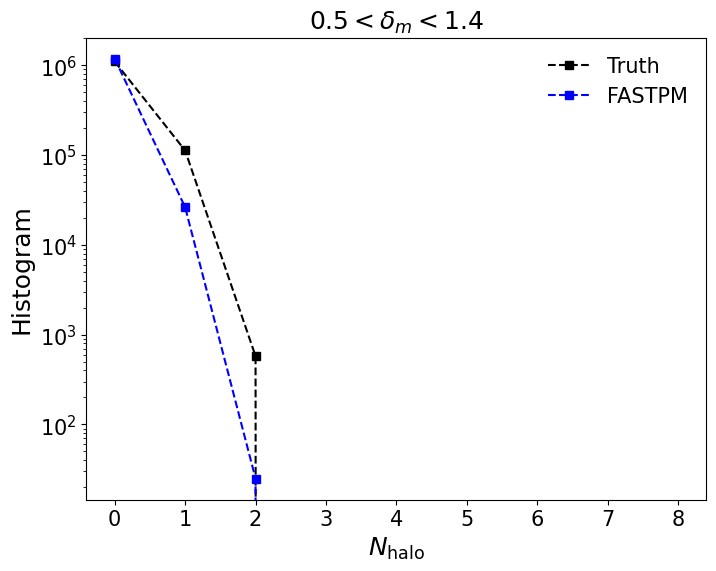

In [19]:
delta_min_p, delta_max_p = 0.5, 1.4
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
pl.figure(figsize=(8,6))
bin_cents = np.array([0,1,2,3,4,5,6,7,8])
bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
bin_edges = np.insert(bin_edges,0, -0.5)
bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] + 0.5)
hist_truth, _ = np.histogram(dfhalo2_ngp[indsel_dp].flatten(), bins=bin_edges)
hist_truth_fp, _ = np.histogram(dfhalo2_ngp_fp[indsel_dp].flatten(), bins=bin_edges)
# _ = pl.hist(df_Nh_truth[indsel_dp].flatten(), histtype='step', bins=[0,1,2,3,4,5,6,7,8], label='Truth')
pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label='Truth')
pl.plot(bin_cents, hist_truth_fp, marker='s', color='b', ls='--', label='FASTPM')
# hist_samp, _ = np.histogram(Nhalos_truth_recomb[indsel_dp].flatten(), bins=bin_edges)
# _ = pl.hist(, bins=[0,1,2,3,4,5,6,7,8], label='Sampled')
# pl.plot(bin_cents, hist_samp, marker='o', color='b', ls='-', label='Sampled')
pl.yscale('log')
pl.legend(fontsize=15, frameon=False)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.xlabel(r'$N_{\rm halo}$', size=18)
pl.ylabel('Histogram', size=18)
pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)




(0.0, 100.0)

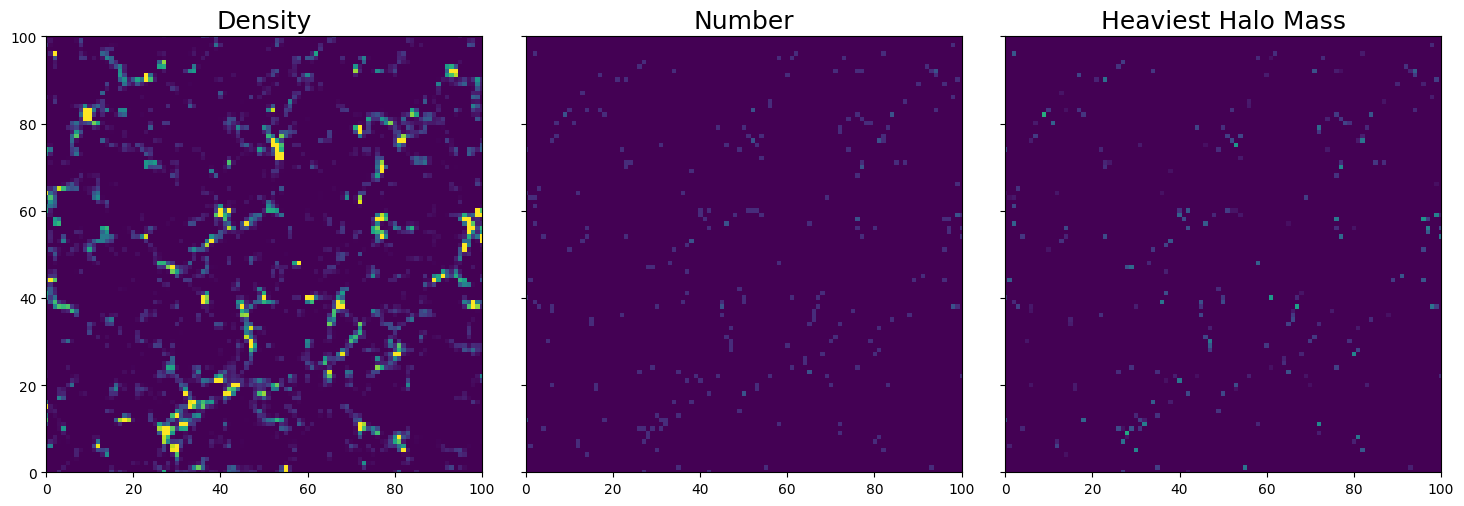

In [10]:
fig, axes = pl.subplots(nrows=1, ncols=3, figsize=(18, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# axes[0].imshow(((mesh_truth.preview(axes=[0,1]))))
# axes[0].set_title('Truth', size=18)
xmin = 0
xmax = 100
axes[0].imshow(df_pylians[64,:,:], vmin=0, vmax=8, origin='lower')
axes[0].set_title('Density', size=18)
axes[0].set_xlim(xmin,xmax)
axes[0].set_ylim(xmin,xmax)

axes[1].imshow(dfhalo2_ngp[64,:,:], vmin=0, vmax=8, origin='lower')
axes[1].set_title('Number', size=18)
axes[1].set_xlim(xmin,xmax)
axes[1].set_ylim(xmin,xmax)

# axes[2].imshow((np.abs(10**M_halos_truth_recomb[64,:,:,0] - 10**M_halos[64,:,:,0])/10**M_halos_truth_recomb[64,:,:,0]), vmin=0, vmax=1.0, origin='lower')
axes[2].imshow(dfhalo_ngp_wmass_sorted[64,:,:, 0], vmin=13, vmax=16, origin='lower')
axes[2].set_title('Heaviest Halo Mass', size=18)
axes[2].set_xlim(xmin,xmax)
axes[2].set_ylim(xmin,xmax)





            


NameError: name 'dfhalo_ngp_wmass_sorted_fp_M0_mat' is not defined

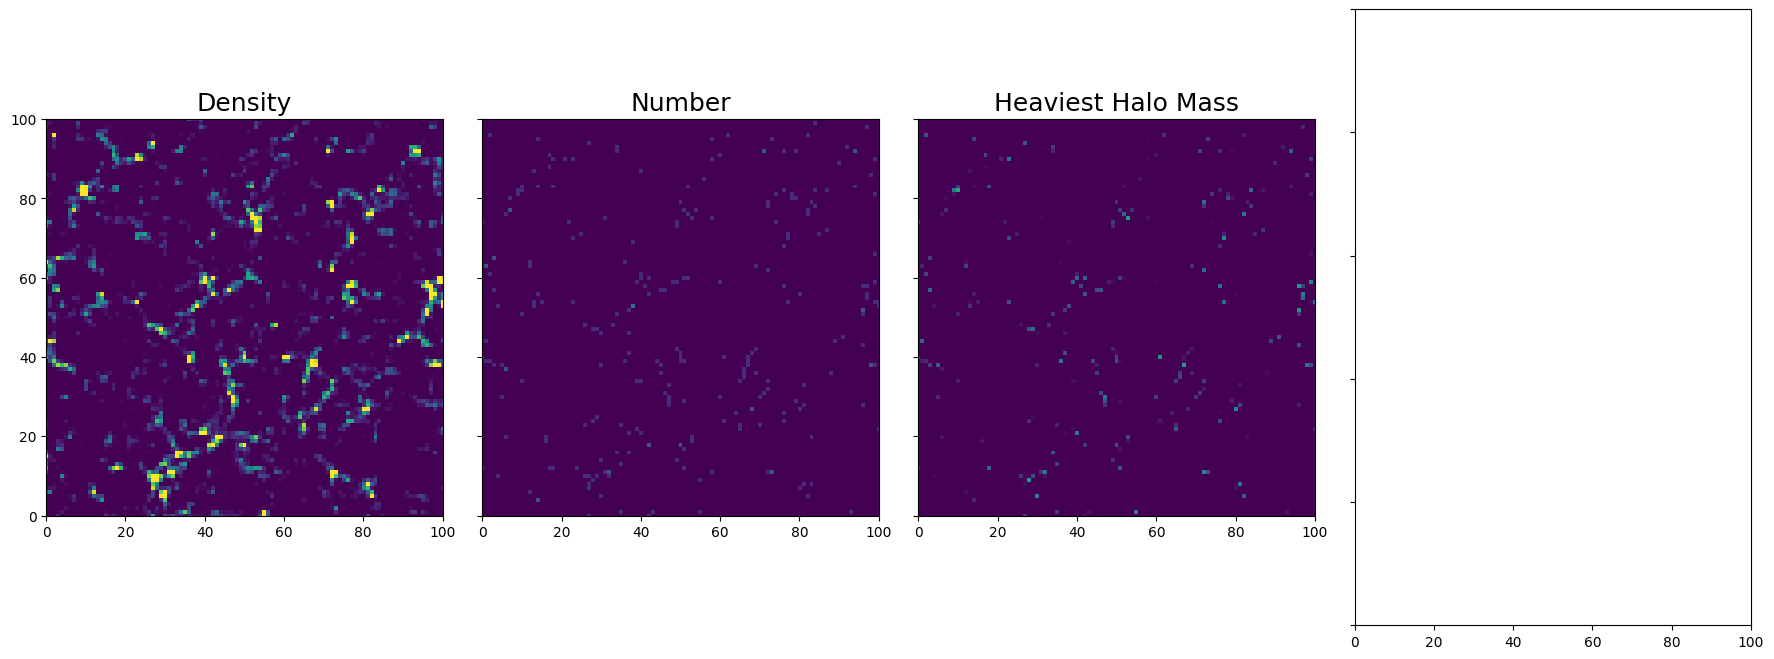

In [11]:
fig, axes = pl.subplots(nrows=1, ncols=4, figsize=(22, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# axes[0].imshow(((mesh_truth.preview(axes=[0,1]))))
# axes[0].set_title('Truth', size=18)
xmin = 0
xmax = 100
axes[0].imshow(df_pylians_fp[64,:,:], vmin=0, vmax=8, origin='lower')
axes[0].set_title('Density', size=18)
axes[0].set_xlim(xmin,xmax)
axes[0].set_ylim(xmin,xmax)

axes[1].imshow(dfhalo2_ngp_fp[64,:,:], vmin=0, vmax=8, origin='lower')
axes[1].set_title('Number', size=18)
axes[1].set_xlim(xmin,xmax)
axes[1].set_ylim(xmin,xmax)

# axes[2].imshow((np.abs(10**M_halos_truth_recomb[64,:,:,0] - 10**M_halos[64,:,:,0])/10**M_halos_truth_recomb[64,:,:,0]), vmin=0, vmax=1.0, origin='lower')
axes[2].imshow(dfhalo_ngp_wmass_sorted_fp[64,:,:, 0], vmin=13, vmax=16, origin='lower')
axes[2].set_title('Heaviest Halo Mass', size=18)
axes[2].set_xlim(xmin,xmax)
axes[2].set_ylim(xmin,xmax)

# axes[2].imshow((np.abs(10**M_halos_truth_recomb[64,:,:,0] - 10**M_halos[64,:,:,0])/10**M_halos_truth_recomb[64,:,:,0]), vmin=0, vmax=1.0, origin='lower')
axes[3].imshow(dfhalo_ngp_wmass_sorted_fp_M0_mat[64,:,:], vmin=13, vmax=16, origin='lower')
axes[3].set_title('Heaviest Halo Mass', size=18)
axes[3].set_xlim(xmin,xmax)
axes[3].set_ylim(xmin,xmax)





            


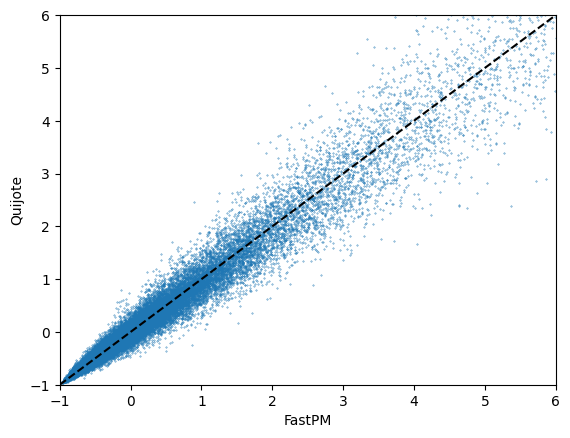

In [12]:
pl.figure()
pl.scatter(df_pylians_fp[64,:,:].flatten(), df_pylians[64,:,:].flatten(), s=0.1)
# pl.xscale('log')
# pl.yscale('log')
pl.xlabel('FastPM')
pl.ylabel('Quijote')
pl.xlim(-1.0, 6.0)
pl.ylim(-1.0, 6.0)
pl.plot([-1.0, 6.0], [-1.0, 6.0], 'k--')


In [39]:
np.amin(dfhalo_ngp_wmass_sorted_rk[dfhalo_ngp_wmass_sorted_rk > 0])


12.699517

Text(0, 0.5, 'Histogram')

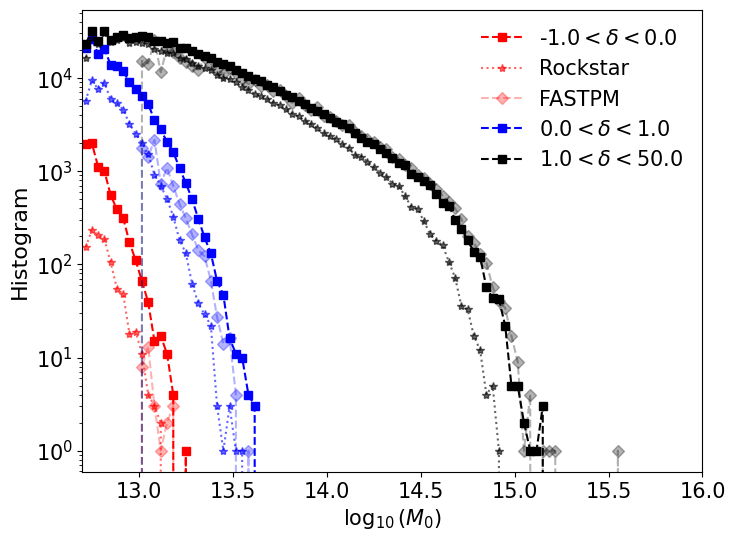

In [43]:
bin_edges = np.linspace(12.7, 16, 100)
bin_cents = 0.5*(bin_edges[1:] + bin_edges[:-1])


pl.figure(figsize=(8,6))
delta_min_p, delta_max_p = -1.0, 0.0
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,0][indsel_dp].flatten(), bins=bin_edges, density=False)
pl.plot(bin_cents, hist_truth, marker='s', color='r', ls='--', label=str(delta_min_p) + r'$ < \delta <$' + str(delta_max_p))

indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted_rk[...,0][indsel_dp].flatten(), bins=bin_edges, density=False)
pl.plot(bin_cents, hist_truth, marker='*', color='r', ls=':', label='Rockstar', alpha=0.6)


indsel_dp = np.where((df_pylians_fp > delta_min_p) & (df_pylians_fp < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted_fp[...,0][indsel_dp].flatten(), bins=bin_edges, density=False)
# pl.plot(bin_cents, hist_truth, marker='D', color='r', ls='--', label=str(delta_min_p) + r'$ < \delta <$' + str(delta_max_p), alpha=0.3)
pl.plot(bin_cents, hist_truth, marker='D', color='r', ls='--', label='FASTPM', alpha=0.3)


delta_min_p, delta_max_p = 0.0, 1.0
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,0][indsel_dp].flatten(), bins=bin_edges, density=False)
pl.plot(bin_cents, hist_truth, marker='s', color='b', ls='--', label=str(delta_min_p) + r'$ < \delta <$' + str(delta_max_p))

indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted_rk[...,0][indsel_dp].flatten(), bins=bin_edges, density=False)
pl.plot(bin_cents, hist_truth, marker='*', color='b', ls=':', alpha=0.6)


indsel_dp = np.where((df_pylians_fp > delta_min_p) & (df_pylians_fp < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted_fp[...,0][indsel_dp].flatten(), bins=bin_edges, density=False)
# pl.plot(bin_cents, hist_truth, marker='D', color='b', ls='--', label=str(delta_min_p) + r'$ < \delta <$' + str(delta_max_p), alpha=0.3)
pl.plot(bin_cents, hist_truth, marker='D', color='b', ls='--', alpha=0.3)



delta_min_p, delta_max_p = 1.0, 50.0
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,0][indsel_dp].flatten(), bins=bin_edges, density=False)
pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label=str(delta_min_p) + r'$ < \delta <$' + str(delta_max_p))

indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted_rk[...,0][indsel_dp].flatten(), bins=bin_edges, density=False)
pl.plot(bin_cents, hist_truth, marker='*', color='k', ls=':', alpha=0.6)


indsel_dp = np.where((df_pylians_fp > delta_min_p) & (df_pylians_fp < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted_fp[...,0][indsel_dp].flatten(), bins=bin_edges, density=False)
# pl.plot(bin_cents, hist_truth, marker='D', color='k', ls='--', label=str(delta_min_p) + r'$ < \delta <$' + str(delta_max_p), alpha=0.3)
pl.plot(bin_cents, hist_truth, marker='D', color='k', ls='--', alpha=0.3)



pl.yscale('log')
pl.xlim(bin_edges[0], bin_edges[-1])
pl.legend(fontsize=15, frameon=False)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.xlabel(r'$\log_{10}(M_{0})$', size=15)
# pl.ylabel('Histogram Density', size=16)
pl.ylabel('Histogram', size=16)
# pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)




In [36]:
# df_pylians_fp
# indsel_dp
# np.amin(df_pylians_fp), np.amax(df_pylians_fp)
10**bin_cents


array([6.54879832e+12, 7.05480231e+12, 7.59990355e+12, 8.18712296e+12,
       8.81971488e+12, 9.50118507e+12, 1.02353102e+13, 1.10261588e+13,
       1.18781136e+13, 1.27958962e+13, 1.37845927e+13, 1.48496826e+13,
       1.59970685e+13, 1.72331091e+13, 1.85646544e+13, 1.99990838e+13,
       2.15443469e+13, 2.32090073e+13, 2.50022906e+13, 2.69341349e+13,
       2.90152464e+13, 3.12571585e+13, 3.36722958e+13, 3.62740427e+13,
       3.90768180e+13, 4.20961545e+13, 4.53487851e+13, 4.88527357e+13,
       5.26274250e+13, 5.66937721e+13, 6.10743124e+13, 6.57933225e+13,
       7.08769549e+13, 7.63533828e+13, 8.22529561e+13, 8.86083700e+13,
       9.54548457e+13, 1.02830326e+14, 1.10775685e+14, 1.19334956e+14,
       1.28555573e+14, 1.38488637e+14, 1.49189196e+14, 1.60716552e+14,
       1.73134588e+14, 1.86512125e+14, 2.00923300e+14, 2.16447979e+14,
       2.33172199e+14, 2.51188643e+14, 2.70597159e+14, 2.91505306e+14,
       3.14028957e+14, 3.38292936e+14, 3.64431712e+14, 3.92590145e+14,
      

/mnt/home/spandey/ceph/.venv/lib/python3.9/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/mnt/home/spandey/ceph/.venv/lib/python3.9/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Text(0, 0.5, 'Histogram Density')

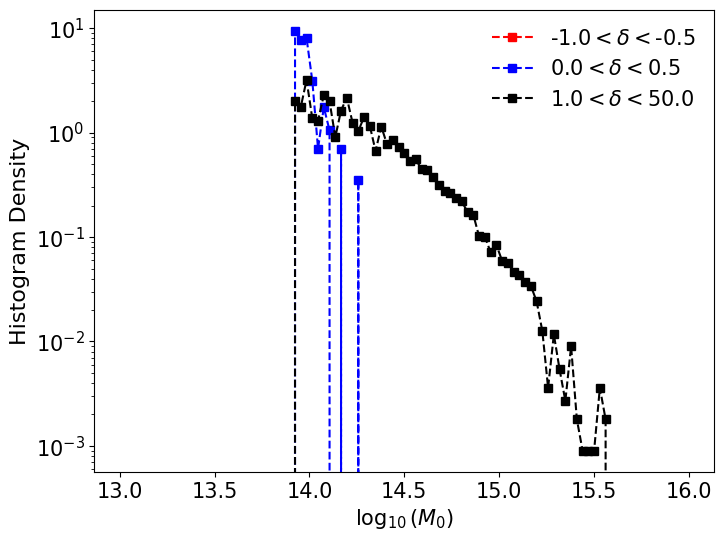

In [100]:
bin_edges = np.linspace(13, 16, 100)
bin_cents = 0.5*(bin_edges[1:] + bin_edges[:-1])


pl.figure(figsize=(8,6))
delta_min_p, delta_max_p = -1.0, -0.5
indsel_dp = np.where((df_pylians_fp > delta_min_p) & (df_pylians_fp < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted_fp[...,0][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='r', ls='--', label=str(delta_min_p) + r'$ < \delta <$' + str(delta_max_p))

delta_min_p, delta_max_p = 0.0, 0.5
indsel_dp = np.where((df_pylians_fp > delta_min_p) & (df_pylians_fp < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted_fp[...,0][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='b', ls='--', label=str(delta_min_p) + r'$ < \delta <$' + str(delta_max_p))


delta_min_p, delta_max_p = 1.0, 50.0
indsel_dp = np.where((df_pylians_fp > delta_min_p) & (df_pylians_fp < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted_fp[...,0][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label=str(delta_min_p) + r'$ < \delta <$' + str(delta_max_p))


pl.yscale('log')
pl.legend(fontsize=15, frameon=False)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.xlabel(r'$\log_{10}(M_{0})$', size=15)
pl.ylabel('Histogram Density', size=16)
# pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)




Text(0.5, 1.0, '1.0$< \\delta_m < $50.0')

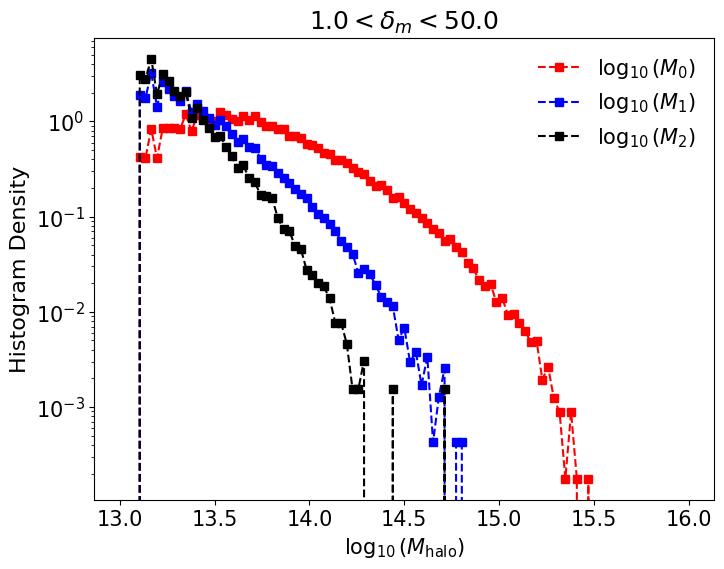

In [37]:
bin_edges = np.linspace(13, 16, 100)
bin_cents = 0.5*(bin_edges[1:] + bin_edges[:-1])


pl.figure(figsize=(8,6))
delta_min_p, delta_max_p = 1.0, 50.0
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,0][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='r', ls='--', label=r'$\log_{10}(M_0)$')

hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,1][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='b', ls='--', label=r'$\log_{10}(M_1)$')

hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,2][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label=r'$\log_{10}(M_2)$')


pl.yscale('log')
pl.legend(fontsize=15, frameon=False)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.xlabel(r'$\log_{10}(M_{\rm halo})$', size=15)
pl.ylabel('Histogram Density', size=16)
pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)




Text(0, 0.5, '$\\log_{10}(M_{0})$')

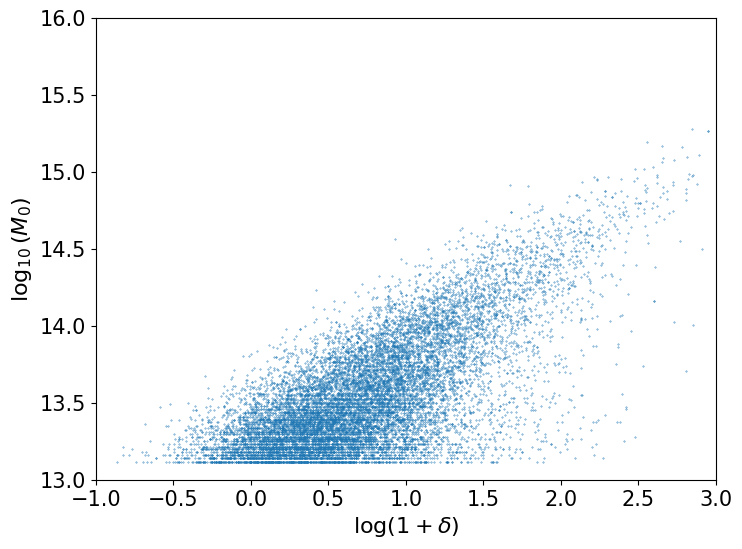

In [101]:
pl.figure(figsize=(8,6))
delta_min_p, delta_max_p = -1.0, 50.0
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
density_list = df_pylians[indsel_dp].flatten()
logM_list = dfhalo_ngp_wmass_sorted[...,0][indsel_dp].flatten()
indsel_rand = np.random.randint(0, len(density_list), np.amin(np.array([len(density_list), 100000])))
pl.scatter(np.log(1+density_list[indsel_rand]),logM_list[indsel_rand], s=0.1)
# pl.xscale('log')
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.ylim(13, 16)
pl.xlim(-1,3)
pl.xlabel(r'$\log(1 + \delta)$', size=16)
pl.ylabel(r'$\log_{10}(M_{0})$', size=16)

# pl.xlim(delta_min_p-0.1, delta_max_p)




Text(0, 0.5, '$\\log_{10}(M_{0})$')

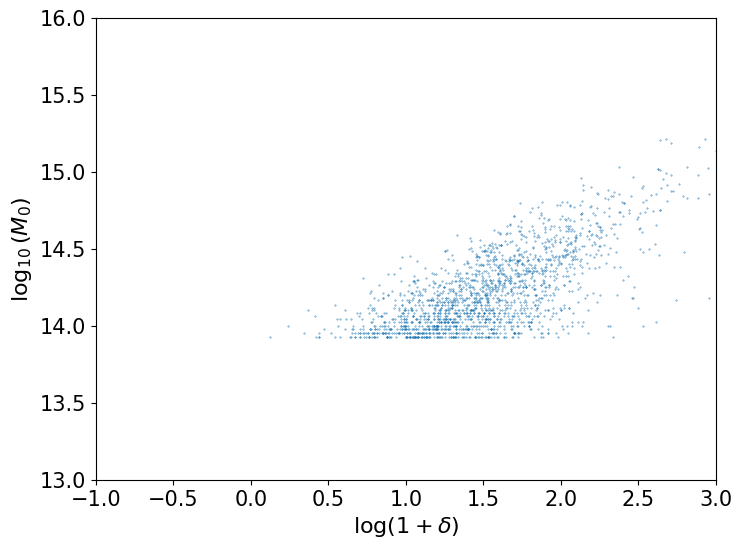

In [102]:
pl.figure(figsize=(8,6))
delta_min_p, delta_max_p = -1.0, 50.0
indsel_dp = np.where((df_pylians_fp > delta_min_p) & (df_pylians_fp < delta_max_p))
density_list = df_pylians_fp[indsel_dp].flatten()
logM_list = dfhalo_ngp_wmass_sorted_fp[...,0][indsel_dp].flatten()
indsel_rand = np.random.randint(0, len(density_list), np.amin(np.array([len(density_list), 100000])))
pl.scatter(np.log(1+density_list[indsel_rand]),logM_list[indsel_rand], s=0.1)
# pl.xscale('log')
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.ylim(13, 16)
pl.xlim(-1,3)
pl.xlabel(r'$\log(1 + \delta)$', size=16)
pl.ylabel(r'$\log_{10}(M_{0})$', size=16)

# pl.xlim(delta_min_p-0.1, delta_max_p)




In [41]:
save_subvol_density_pad = df_density_subvol['density_ngp_pad']
save_subvol_density_unpad = df_density_subvol['density_ngp_unpad']
save_subvol_Nhalo = df_halos_subvol['N_halos']
save_subvol_Mhalo = df_halos_subvol['M_halos']



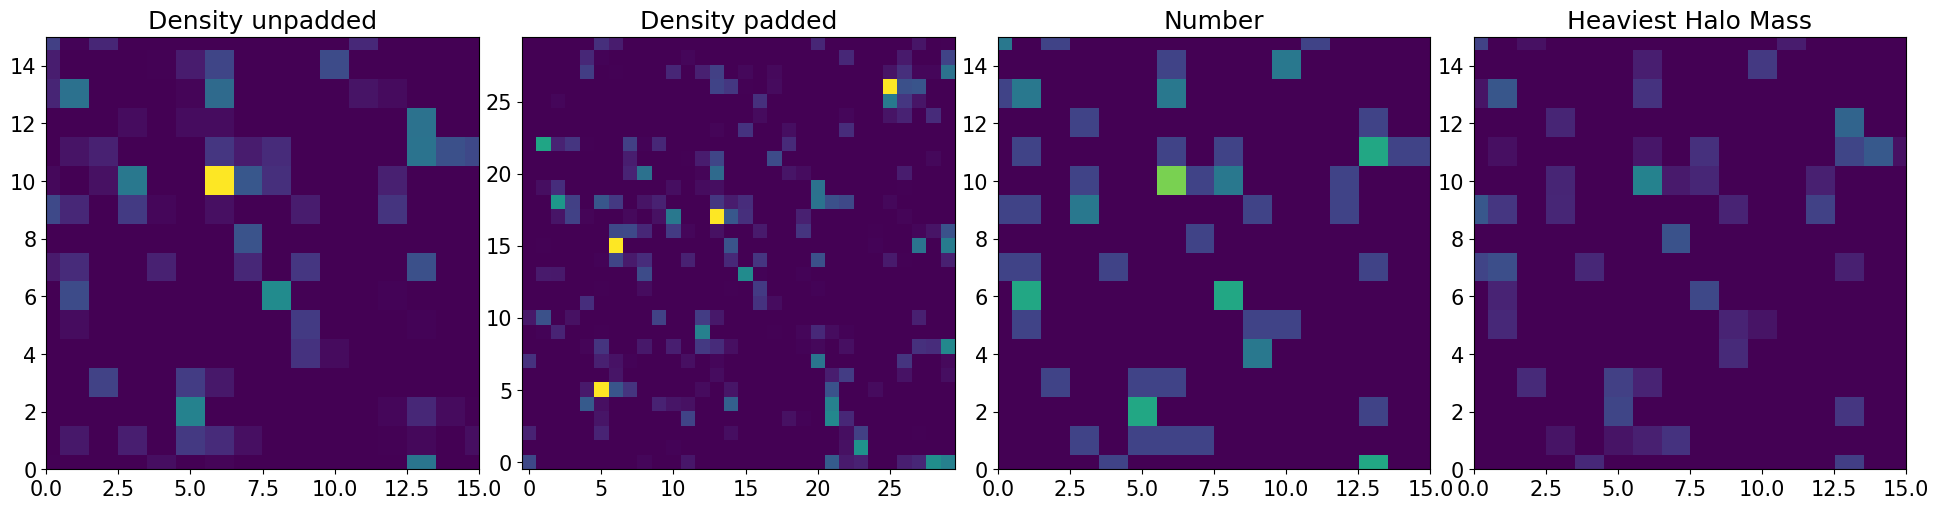

In [42]:
fig, axes = pl.subplots(nrows=1, ncols=4, figsize=(24, 8))
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# axes[0].imshow(((mesh_truth.preview(axes=[0,1]))))
# axes[0].set_title('Truth', size=18)
xmin = 0
xmax = 15
axes[0].imshow(save_subvol_density_unpad[0,8,...], vmin=0, vmax=8, origin='lower')
axes[0].set_title('Density unpadded', size=18)
axes[0].set_xlim(xmin,xmax)
axes[0].set_ylim(xmin,xmax)
axes[0].tick_params(axis='both', which='major', labelsize=15)
axes[0].tick_params(axis='both', which='minor', labelsize=15)


axes[1].imshow(save_subvol_density_pad[0, n_pad + 8,...], vmin=0, vmax=8, origin='lower')
axes[1].set_title('Density padded', size=18)
# axes[1].set_xlim(xmin+n_pad,xmax+n_pad)
# axes[1].set_ylim(xmin+n_pad,xmax+n_pad)
axes[1].tick_params(axis='both', which='major', labelsize=15)
axes[1].tick_params(axis='both', which='minor', labelsize=15)


# axes[2].imshow((np.abs(10**M_halos_truth_recomb[64,:,:,0] - 10**M_halos[64,:,:,0])/10**M_halos_truth_recomb[64,:,:,0]), vmin=0, vmax=1.0, origin='lower')
axes[2].imshow(save_subvol_Nhalo[0,8,...], vmin=0, vmax=5, origin='lower')
axes[2].set_title('Number', size=18)
axes[2].set_xlim(xmin,xmax)
axes[2].set_ylim(xmin,xmax)
axes[2].tick_params(axis='both', which='major', labelsize=15)
axes[2].tick_params(axis='both', which='minor', labelsize=15)


axes[3].imshow(save_subvol_Mhalo[..., 0][0,8,...], vmin=13, vmax=16, origin='lower')
axes[3].set_title('Heaviest Halo Mass', size=18)
axes[3].set_xlim(xmin,xmax)
axes[3].set_ylim(xmin,xmax)
axes[3].tick_params(axis='both', which='major', labelsize=15)
axes[3].tick_params(axis='both', which='minor', labelsize=15)





            



